In [122]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset


%matplotlib widget
%load_ext autoreload
%autoreload 2
from stressgait_analysis.gait_helper_functions import compute_HS
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [93]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

In [94]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)

load the kinematics of all participants. Then multiple ways are possible, here I average all gait cycles first per participant and speed, then I divide into OMC participants and controls for fast and slow

In [95]:
kinematics = dataset.kinematics.droplevel(level="bout")
cycle_averaged_q = kinematics.groupby(["participant", "condition", "speed", "percentage_of_stride"]).mean()
cycle_averaged_q.head()

hip_flexion  knee_flexion  \
participant condition speed percentage_of_stride                              
VP_01       omc       fast  0                       16.672305     -1.643508   
                            1                       16.742015     -1.106875   
                            2                       16.800376     -0.381644   
                            3                       16.813459      0.991988   
                            4                       16.754319      2.397110   

                                                  ankle_plantarflexion  \
participant condition speed percentage_of_stride                         
VP_01       omc       fast  0                                -1.108192   
                            1                                -1.004262   
                            2                                -0.801543   
                            3                                -0.248121   
                            4                                 0.490823   

                                                  elbow_flexion_angles  \
participant condition speed percentage_of_stride                         
VP_01       omc       fast  0                                 6.636294   
                            1                                 6.273802   
                            2                                 5.890098   
                            3                                 5.431165   
                            4                                 4.946220   

                                                  arm_swing_angles  
participant condition speed percentage_of_stride                    
VP_01       omc       fast  0                            12.026410  
                            1                            12.471050  
                            2                            12.884937  
                            3                            13.189956  
                            4                            13.429218

In [121]:
c = cycle_averaged_q.reset_index()
p0 = c[c.percentage_of_stride == 1]
p0[p0['ankle_plantarflexion'] <-20]

,participant,condition,speed,percentage_of_stride,responder,hip_flexion,knee_flexion,ankle_plantarflexion,elbow_flexion_angles,arm_swing_angles
6869,VP_41,omc,fast,1,0,17.570671,1.247244,-151.075045,16.307562,12.867791


split into omc / control as well as fast / slow

In [96]:
omc_kinematics_slow = cycle_averaged_q.xs(("omc", "slow"), level=("condition", "speed"))
omc_kinematics_fast = cycle_averaged_q.xs(("omc", "fast"), level=("condition", "speed"))

control_kinematics_slow = cycle_averaged_q.xs(("control", "slow"), level=("condition", "speed"))
control_kinematics_fast = cycle_averaged_q.xs(("control", "fast"), level=("condition", "speed"))

In [134]:
omc_fast_ankle[omc_fast_ankle.iloc[:,10] > 20]

percentage_of_stride,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
participant,,,,,,,,,,,,,,,,,,,,,
VP_35,51.132295,50.909191,50.731503,51.167264,51.656082,52.538132,53.42421,54.132633,54.669116,54.614358,...,9.804562,9.616287,9.159344,8.608978,8.039594,7.489812,6.836726,6.150839,5.500456,4.854048


<Axes: xlabel='percentage_of_stride'>

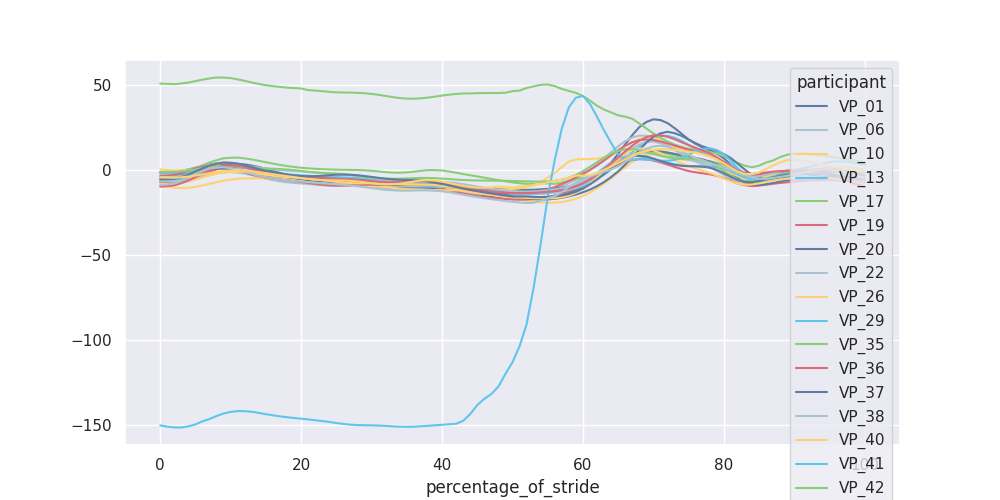

In [130]:
omc_fast_ankle.T.plot() #the weird ones are VP14_fast and VP35 fast

for spm, we need data in the format J x Q, where J are the participants per group and Q are the nodes

In [97]:
omc_slow_hip = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
omc_slow_knee = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")
omc_slow_ankle = omc_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="ankle_plantarflexion")

control_slow_hip = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
control_slow_knee = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")
control_slow_ankle = control_kinematics_slow.reset_index().pivot(index="participant", columns="percentage_of_stride", values="ankle_plantarflexion")



omc_fast_hip = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
omc_fast_knee = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")
omc_fast_ankle = omc_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="ankle_plantarflexion")


control_fast_hip = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="hip_flexion")
control_fast_knee = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")
control_fast_ankle = control_kinematics_fast.reset_index().pivot(index="participant", columns="percentage_of_stride", values="ankle_plantarflexion")


In [123]:
control_slow_hip

percentage_of_stride,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
participant,,,,,,,,,,,,,,,,,,,,,
VP_02,19.220460,19.011316,18.852513,18.810023,18.754855,18.690897,18.495138,18.241516,17.815053,17.254127,...,25.487171,24.867463,24.156070,23.371275,22.565394,21.756646,20.982126,20.269718,19.709929,19.219405
VP_05,8.726673,8.660184,8.563411,8.403636,8.132415,7.797691,7.306410,6.774201,6.172768,5.568999,...,12.851237,12.242287,11.526462,10.821703,10.139737,9.638611,9.225782,8.971290,8.824327,8.730372
VP_07,15.123897,14.958506,14.788884,14.628129,14.460165,14.297468,14.122969,13.918564,13.640923,13.223300,...,17.791449,17.403198,16.969662,16.562446,16.184102,15.904970,15.658743,15.468266,15.290741,15.120549
VP_08,9.501276,8.644200,7.741900,6.780587,5.679124,4.493082,3.204659,1.868575,0.551871,-0.676629,...,15.488629,14.919476,14.303202,13.677813,13.043027,12.399068,11.741068,11.032142,10.281792,9.498187
VP_11,17.679897,17.643779,17.602232,17.502382,17.393305,17.244331,17.085116,16.905979,16.696153,16.444560,...,20.224747,19.673028,19.184573,18.733458,18.387068,18.083873,17.905024,17.756178,17.707286,17.668187
VP_12,22.380691,21.932943,21.485959,21.043036,20.585712,20.082223,19.543432,18.945555,18.306677,17.634454,...,28.738699,27.799425,26.881620,26.022950,25.265268,24.573180,23.967032,23.387662,22.875393,22.372765
VP_15,19.173565,19.120648,19.067204,19.005259,18.928908,18.817872,18.722573,18.646747,18.642871,18.684367,...,20.192384,20.268990,20.284994,20.199020,20.051346,19.853979,19.648836,19.444695,19.305003,19.178670
VP_16,11.196180,10.793405,10.362884,9.818909,9.209193,8.502580,7.736372,6.936738,6.146435,5.364834,...,15.205743,14.611651,14.017793,13.457898,12.951402,12.523967,12.157410,11.831098,11.508958,11.187900
VP_18,20.830042,20.541682,20.254709,19.966989,19.606979,19.183465,18.628700,17.915817,17.108204,16.139969,...,27.751595,26.853137,25.866662,24.869690,23.908879,23.054476,22.279609,21.686476,21.214358,20.824961


In [104]:
def plot_result(YA, YB, ti):
### plot mean and SD:
    fig = plt.figure( figsize=(8, 3.5) )
    ax     = plt.axes( (0.1, 0.15, 0.35, 0.8) )
    spm1d.plot.plot_mean_sd(YA, linecolor=palette[0],label="omc", facecolor=palette[0], ax=ax)
    spm1d.plot.plot_mean_sd(YB,  linecolor=palette[-1], label= "control", facecolor=palette[-1], ax=ax)
    ax.axhline(y=0, color='k', linestyle=':')
    ax.set_xlabel('Time (%)')
    plt.legend()
    ### plot SPM results:
    ax= plt.axes((0.55,0.15,0.35,0.8))
    ti.plot()
    ti.plot_threshold_label(fontsize=8)
    ti.plot_p_values(size=10, offsets=[(0,0.3)])
    ax.set_xlabel('Time (%)')
    return fig

## SPM for the hip

### slow

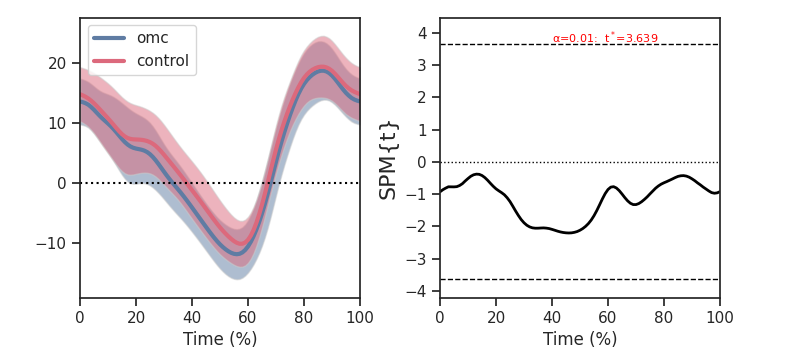

In [105]:
t = spm1d.stats.ttest2(np.array(omc_slow_hip), np.array(control_slow_hip))
ti = t.inference(alpha=0.0083)
figure = plot_result(omc_slow_hip, control_slow_hip, ti)

### fast

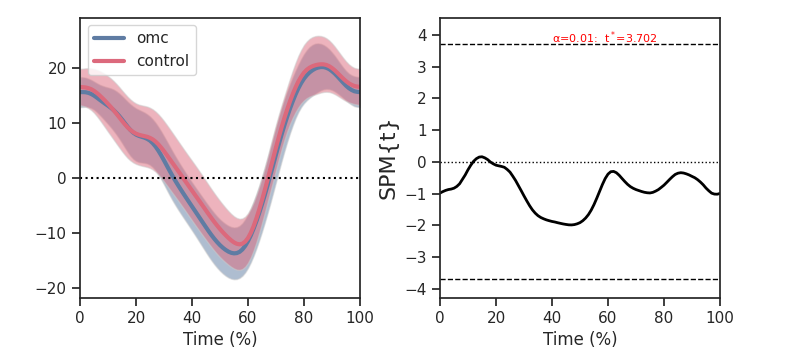

In [106]:
t = spm1d.stats.ttest2(np.array(omc_fast_hip), np.array(control_fast_hip))
ti = t.inference(alpha=0.05/6)
figure = plot_result(omc_fast_hip, control_fast_hip, ti)

## knee

### slow

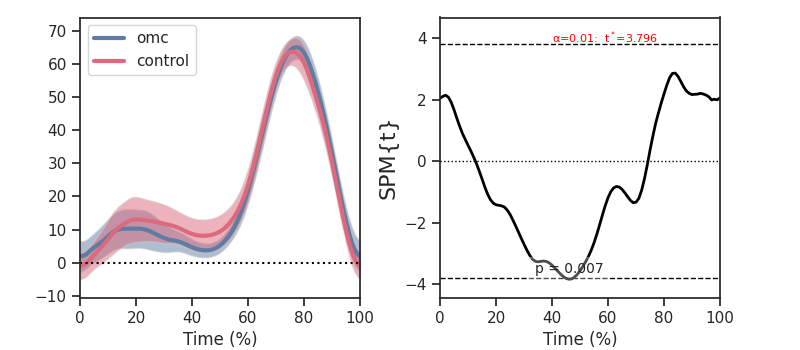

In [107]:
t = spm1d.stats.ttest2(np.array(omc_slow_knee), np.array(control_slow_knee))
ti = t.inference(alpha=0.05/6)
figure = plot_result(omc_slow_knee, control_slow_knee, ti)

### fast

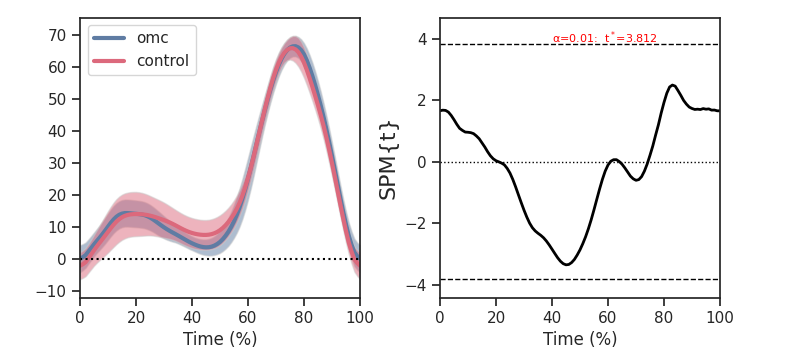

In [108]:
t = spm1d.stats.ttest2(np.array(omc_fast_knee), np.array(control_fast_knee))
ti = t.inference(alpha=0.05/6)
figure = plot_result(omc_fast_knee, control_fast_knee, ti)

## ankle

slow

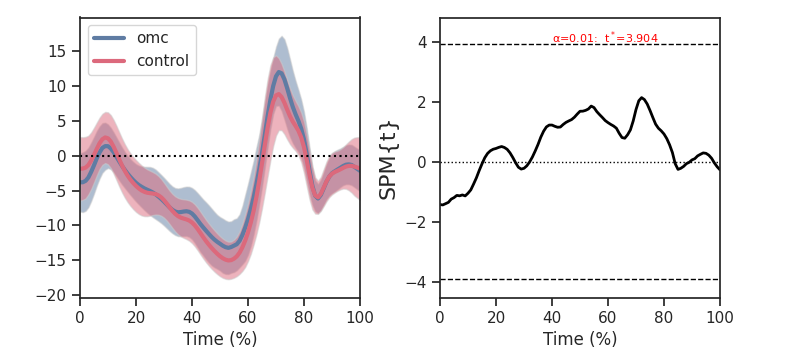

In [109]:
t = spm1d.stats.ttest2(np.array(omc_slow_ankle), np.array(control_slow_ankle))
ti = t.inference(alpha=0.05/6)
figure = plot_result(omc_slow_ankle, control_slow_ankle, ti)

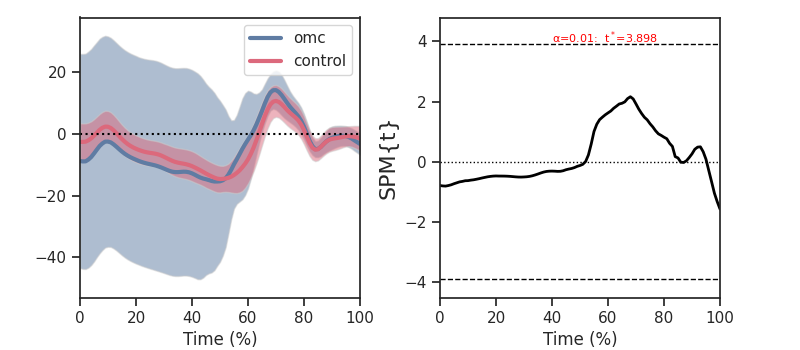

In [110]:
t = spm1d.stats.ttest2(np.array(omc_fast_ankle), np.array(control_fast_ankle))
ti = t.inference(alpha=0.05/6)
figure = plot_result(omc_fast_ankle, control_fast_ankle, ti)

# check responders

In [111]:
cycle_averaged_q = kinematics.groupby(["participant", "condition", "speed", "percentage_of_stride"]).mean()
cycle_averaged_q.head()
c = cycle_averaged_q.reset_index()
c

,participant,condition,speed,percentage_of_stride,hip_flexion,knee_flexion,ankle_plantarflexion,elbow_flexion_angles,arm_swing_angles
0,VP_01,omc,fast,0,16.672305,-1.643508,-1.108192,6.636294,12.026410
1,VP_01,omc,fast,1,16.742015,-1.106875,-1.004262,6.273802,12.471050
2,VP_01,omc,fast,2,16.800376,-0.381644,-0.801543,5.890098,12.884937
3,VP_01,omc,fast,3,16.813459,0.991988,-0.248121,5.431165,13.189956
4,VP_01,omc,fast,4,16.754319,2.397110,0.490823,4.946220,13.429218
...,...,...,...,...,...,...,...,...,...
8277,VP_47,omc,slow,96,19.038657,18.334700,0.340625,24.638156,5.154072
8278,VP_47,omc,slow,97,18.706096,15.990487,0.144513,24.357371,5.462810
8279,VP_47,omc,slow,98,18.331759,14.138599,0.093771,24.124597,5.709183
8280,VP_47,omc,slow,99,17.919661,12.764022,0.120456,23.922619,5.898325


In [112]:
responder_list = ["VP_02", "VP_05", "VP_06", "VP_15", "VP_16", "VP_17", "VP_24", "VP_35", "VP_36", "VP_43", "VP_45", "VP47"]
cycle_averaged_q["responder"] = [1 if r[1].participant in responder_list else 0 for r in c.iterrows()]
cycle_averaged_q.set_index("responder", append=True, inplace=True)

In [113]:
cycle_averaged_q

hip_flexion  \
participant condition speed percentage_of_stride responder                
VP_01       omc       fast  0                    0            16.672305   
                            1                    0            16.742015   
                            2                    0            16.800376   
                            3                    0            16.813459   
                            4                    0            16.754319   
...                                                                 ...   
VP_47       omc       slow  96                   0            19.038657   
                            97                   0            18.706096   
                            98                   0            18.331759   
                            99                   0            17.919661   
                            100                  0            17.486822   

                                                            knee_flexion  \
participant condition speed percentage_of_stride responder                 
VP_01       omc       fast  0                    0             -1.643508   
                            1                    0             -1.106875   
                            2                    0             -0.381644   
                            3                    0              0.991988   
                            4                    0              2.397110   
...                                                                  ...   
VP_47       omc       slow  96                   0             18.334700   
                            97                   0             15.990487   
                            98                   0             14.138599   
                            99                   0             12.764022   
                            100                  0             11.682882   

                                                            ankle_plantarflexion  \
participant condition speed percentage_of_stride responder                         
VP_01       omc       fast  0                    0                     -1.108192   
                            1                    0                     -1.004262   
                            2                    0                     -0.801543   
                            3                    0                     -0.248121   
                            4                    0                      0.490823   
...                                                                          ...   
VP_47       omc       slow  96                   0                      0.340625   
                            97                   0                      0.144513   
                            98                   0                      0.093771   
                            99                   0                      0.120456   
                            100                  0                      0.191702   

                                                            elbow_flexion_angles  \
participant condition speed percentage_of_stride responder                         
VP_01       omc       fast  0                    0                      6.636294   
                            1                    0                      6.273802   
                            2                    0                      5.890098   
                            3                    0                      5.431165   
                            4                    0                      4.946220   
...                                                                          ...   
VP_47       omc       slow  96                   0                     24.638156   
                            97                   0                     24.357371   
                            98                   0                     24.124597   
                            99                   0                     23.9226

In [114]:
kin_responder = cycle_averaged_q.xs((1, "slow"), level=("responder", "speed"))
kin_non_responder= cycle_averaged_q.xs((0, "slow"), level=("responder", "speed"))

In [115]:
responder_knee = kin_responder.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")
non_responder_knee = kin_non_responder.reset_index().pivot(index="participant", columns="percentage_of_stride", values="knee_flexion")


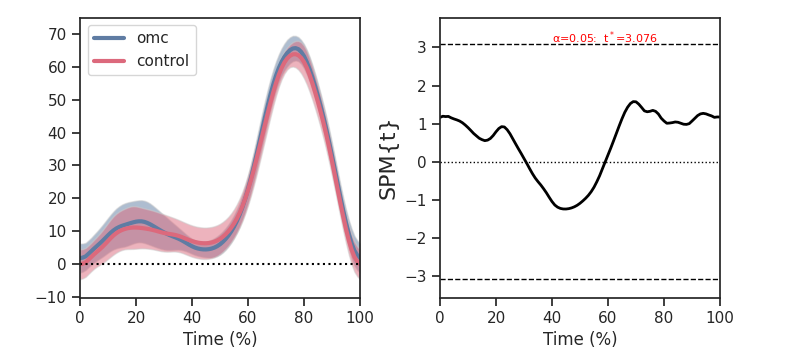

In [116]:
t = spm1d.stats.ttest2(np.array(responder_knee), np.array(non_responder_knee))
ti = t.inference(alpha=0.05)
figure = plot_result(responder_knee, non_responder_knee, ti)